MAKE a RF Regressor with MultioutputRegressor
- Split into 50/50 for now because mac cannot deal with the dataset
- Standardise it after


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import root_mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data

inputs = pd.read_csv('../data/i3PCF_sobol_training_2.6e5_nodes_part1.csv')  # Adjust path as needed
targets = np.load('../data/P_nl_grids_l80_shear_x_shear_COSMOGRIDV1_fiducial_no_neutrinos_i3PCF_sobol_training_2.6e5_nodes_part1.npy')


# 1. First, split the data
X_train, X_test, y_train, y_test = train_test_split(
    inputs, targets, test_size=0.7, random_state=42
)

# 2. Fit the scaler only on training data
scaler_inputs = StandardScaler()
X_train_scaled = scaler_inputs.fit_transform(X_train)
scaler_outputs = StandardScaler()
y_train_scaled = scaler_outputs.fit_transform(y_train)

# 3. Transform test data using the same scaler 
# (using parameters learned from training data)
X_test_scaled = scaler_inputs.transform(X_test)
y_test_scaled = scaler_outputs.transform(y_test)
print(X_test_scaled.shape)

# Multi-output Random Forest Regressor
rf_regressor = MultiOutputRegressor(RandomForestRegressor(
    n_estimators=80, 
    random_state=42, 
    n_jobs=5
))

# Train the model
rf_regressor.fit(X_train_scaled[:3000], y_train_scaled[:3000])

# Predictions
y_pred = rf_regressor.predict(X_test_scaled)
y_pred = y_pred[:200]
y_test = y_test_scaled[:200]

# Evaluate the model
mse = root_mean_squared_error(y_test, y_pred, multioutput='raw_values')
r2 = r2_score(y_test, y_pred, multioutput='raw_values')

# Visualization of predictions vs actual for first few targets
plt.figure(figsize=(15, 5))
for i in range(min(25, y_test.shape[1])):
    plt.subplot(1, 25, i+1)
    plt.scatter(y_test[:, i], y_pred[:, i], alpha=0.5)
    plt.plot([y_test[:, i].min(), y_test[:, i].max()], 
             [y_test[:, i].min(), y_test[:, i].max()], 
             'r--', lw=2)
    plt.title(f'Target {i+1}: Predicted vs Actual')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
plt.tight_layout()
plt.savefig('rf_predictions.png')
plt.close()

# Print performance metrics
print("Random Forest Multi-Output Regression Results:")
print("Mean Squared Errors:", mse)
print("R2 Scores:", r2)

# Feature importance
feature_names = ['Omega_m', 'A_s', 'w0', 'h', 'z', 'c_min'][:3]
importances = np.mean([estimator.feature_importances_ for estimator in rf_regressor.estimators_], axis=0)
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importances')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.close()

print("\nFeature Importances:")
print(feature_importance)

(183501, 6)


In [24]:
# plot
import numpy as np
import matplotlib.pyplot as plt
import math

def adaptive_prediction_scatter(y_test, y_pred, title='Prediction Scatter', 
                                 max_cols=5, max_rows=5, figsize=(20, 15)):
    """
    Adaptively plot prediction scatter plots for multiple targets.
    
    Parameters:
    - y_test: Actual target values
    - y_pred: Predicted target values
    - title: Figure title
    - max_cols: Maximum number of columns in subplot grid
    - max_rows: Maximum number of rows in subplot grid
    - figsize: Figure size
    """
    # Determine number of targets
    num_targets = y_test.shape[1]
    
    # Calculate grid dimensions
    num_cols = min(max_cols, num_targets)
    num_rows = math.ceil(num_targets / num_cols)
    
    # Create figure with adaptive sizing
    plt.figure(figsize=figsize)
    plt.suptitle(title, fontsize=16)
    
    # Plot scatter for each target
    for i in range(num_targets):
        plt.subplot(num_rows, num_cols, i+1)
        plt.scatter(y_test[:, i], y_pred[:, i], alpha=0.5, s=10)
        
        # Perfect prediction line
        min_val = min(y_test[:, i].min(), y_pred[:, i].min())
        max_val = max(y_test[:, i].max(), y_pred[:, i].max())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
        
        # Compute R2 score for this target
        r2 = r2_score(y_test[:, i], y_pred[:, i])
        
        plt.title(f'Target {i+1}\nR2: {r2:.4f}', fontsize=8)
        plt.xlabel('Actual', fontsize=8)
        plt.ylabel('Predicted', fontsize=8)
        plt.tick_params(axis='both', which='major', labelsize=6)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('adaptive_predictions.png', dpi=300)
    plt.close()

adaptive_prediction_scatter(y_test[:, :30], y_pred[:, :30])



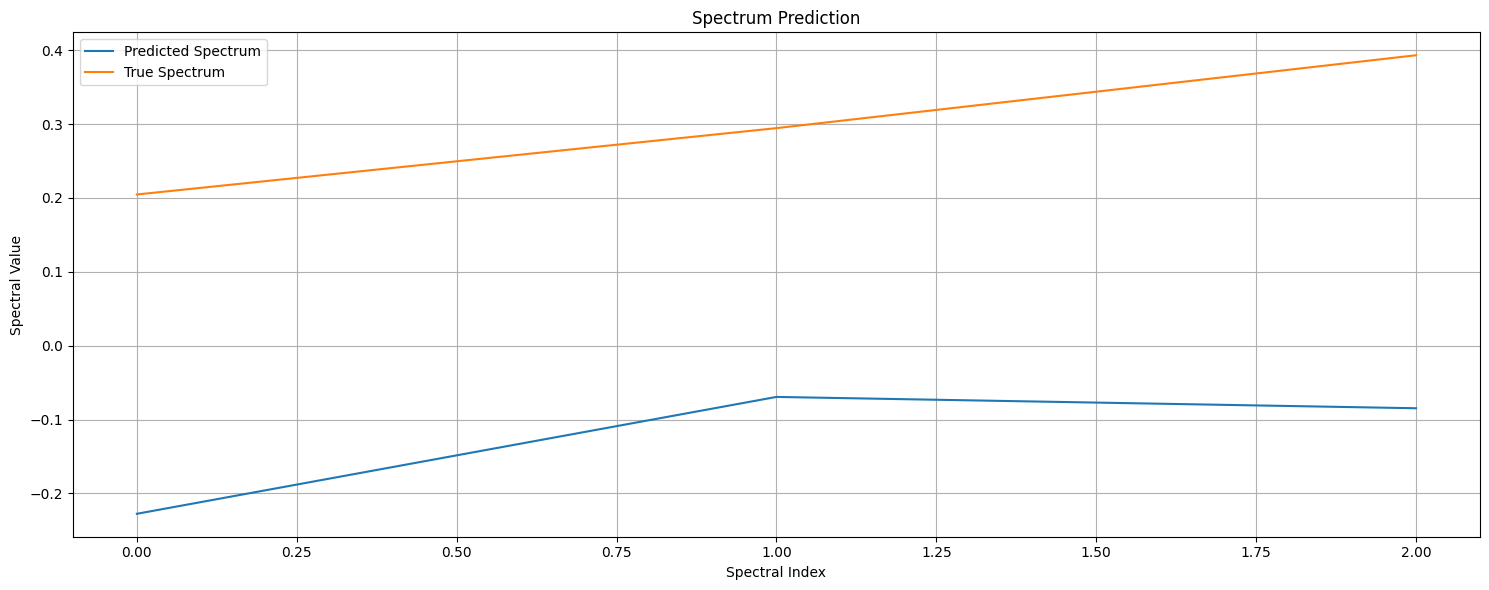

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def plot_spectrum_prediction(model, input_row, output_row=None,
                              input_scaler=None, 
                              output_scaler=None, 
                              is_pytorch=False,
                              title="Spectrum Prediction",
                              show=True):
    """
    Generate and plot spectrum prediction with proper scaling.
    
    Parameters:
    - model: Trained model (PyTorch or RandomForest)
    - input_row: Single input row to generate prediction
    - input_scaler: Optional scaler for input normalization
    - output_scaler: Optional scaler for output denormalization
    - is_pytorch: Flag to indicate PyTorch or sklearn model
    - title: Plot title
    """
    # Prepare input
    if input_scaler is not None:
        input_row_scaled = input_scaler.transform(input_row.reshape(1, -1))
    else:
        input_row_scaled = input_row.reshape(1, -1)
    
    # Generate prediction based on model type
    if is_pytorch:
        # PyTorch model prediction
        model.eval()
        with torch.no_grad():
            input_tensor = torch.FloatTensor(input_row_scaled)
            prediction = model(input_tensor).numpy()
    else:
        # Sklearn model prediction
        prediction = model.predict(input_row_scaled)
    
    # Denormalize prediction if scaler is provided
    if output_scaler is not None:
        prediction = output_scaler.inverse_transform(prediction)
    
    # Flatten prediction in case of multi-dimensional array
    prediction = prediction.flatten()
    
    # Plot the spectrum
    plt.figure(figsize=(15, 6))
    plt.plot(prediction, label='Predicted Spectrum')
    if output_row is not None:
        plt.plot(output_row, label='True Spectrum')
    plt.title(title)
    plt.xlabel('Spectral Index')
    plt.ylabel('Spectral Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('spectrum_prediction.png')
    if show:
        plt.show
        # plt.close()

    return prediction

# Example usage context:
# For Random Forest:
spectrum = plot_spectrum_prediction(
    rf_regressor, 
    X_test_scaled[40, :3], 
    output_row=y_test[40, :],
    input_scaler=None,  # or StandardScaler if used
    output_scaler=None, 
    is_pytorch=False
)
# print(y_test.shape)
# For PyTorch:
# spectrum = plot_spectrum_prediction(
#     model, 
#     X_test[0], 
#     input_scaler=None,
#     output_scaler=output_scaler, 
#     is_pytorch=True
# )

In [28]:
# load a model
from torch import nn
class MLP(nn.Module):
  '''
    Multilayer Perceptron for regression.
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(6, 64),
      nn.ReLU(),
      nn.Linear(64, 128),
      nn.ReLU(),
      nn.Linear(128, 80)
    )
 
  def forward(self, x):
    '''
      Forward pass
    '''
    return self.layers(x)

In [43]:
mlp = MLP()
ckpt = torch.load("/Users/sam/Downloads/mlp_model_best.pth", weights_only=True)
mlp.load_state_dict(ckpt)
mlp.eval()

odict_keys(['layers.0.weight', 'layers.0.bias', 'layers.2.weight', 'layers.2.bias', 'layers.4.weight', 'layers.4.bias'])


MLP(
  (layers): Sequential(
    (0): Linear(in_features=6, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=80, bias=True)
  )
)